## Reproducing the envelope paper stuff

For Anthony. Will attempt to reproduce **Figure 2** and **Figure 3** of [arXiv:1408.6865](https://arxiv.org/pdf/1408.6865)

Start from the dataset I provided which looks like:
```
Low Edge  Up Edge Bin Count
 110.00   110.25   46
 110.25   110.50   52
 110.50   110.75   45
...
...
...
 149.25   149.50   10
 149.50   149.75   13
 149.75   150.00    8


```

The file is stored at `data/envelope_data.log`

In [1]:
## this code will read the bin edges and counts from the file
import numpy as np

bin_edges = []
bin_counts = []

with open('data/envelope_data.log') as f:
    lines = f.readlines()
    for line in lines[1:]:
        low, upper, count = line.split()
        bin_edges.append( float(low) )
        bin_counts.append( int(count) )
    bin_edges.append( float(upper) )

bin_edges = np.asarray( bin_edges )
bin_counts = np.asarray( bin_counts )
assert( len(bin_edges) == len(bin_counts)+1 )

n_events = sum( bin_counts )

### Does it looks like Anthony's plot?

- Yes, although I also plot the per-bin error using the square-root of the count.

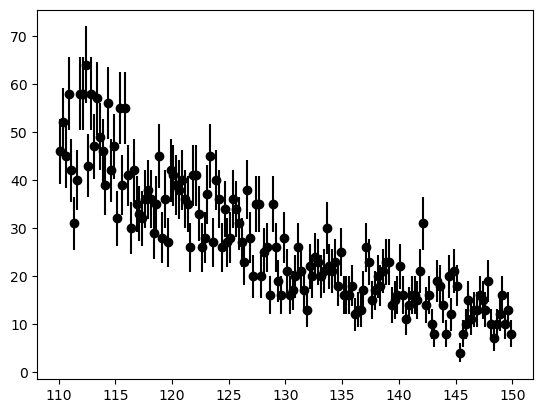

In [2]:
import matplotlib.pyplot as plt

bin_centers = 0.5 * ( bin_edges[1:] + bin_edges[:-1] )

_ = plt.errorbar( bin_centers, bin_counts, bin_counts**0.5, fmt='ko')

### Now I try to reproduce the fits

First to demist some of the jargon:

 - the signal is a Gaussian with mean 125 and a "width" (which is the standard deviation) of 1.19
 - when we refer to the normalisation of 50.8 events what we mean is that instead of fitting the number of signal events we fit a "signal strength" parameter, $\mu$, which takes a value of $\mu=1$ when the number of signal is 50.8 


### Need to define some background functions (and the signal function for this)

It seems from our definitions in the paper we also use a $p_0$ parameter at the front but I'll keep this out of the background definition (it can just be absorbed into the overall scale of the background).

For each background function (I don't bother with the polynomial) I define the function (called `raw_pdf`) and then its integral (called `raw_cdf`). I then normalise these to unity in the valid range of the random variable, $x \in [110,150]$

I also notice an awkward typo in the paper in which we define the Laurent series as $p_0 x^4 + p_1 x^5$ but these should be negative powers, i.e. $p_0 x^{-4} + p_1 x^{-5}$

In [3]:
# set the range for normalisation
xrange = (110, 150)

#### The Power law
 - pdf: $f(x) = N x^{p}$
 - cdf: $F(x) = N \frac{x^{p+1}}{p+1}$

In [4]:
def power_law_raw_pdf(x, p):
    _x = np.asarray(x, dtype=np.float64)
    return _x**p

def power_law_raw_cdf(x, p):
    _x = np.asarray(x, dtype=np.float64)
    return _x**(p+1) / (p+1)

def power_law_pdf(x, p):
    N = np.diff( power_law_raw_cdf(xrange, p) )
    return power_law_raw_pdf(x, p) / N

def power_law_cdf(x, p):
    delta = power_law_raw_cdf(xrange[0], p)
    N = np.diff( power_law_raw_cdf(xrange, p) )
    return ( power_law_raw_cdf(x, p) - delta ) / N

#### The Exponential
 - pdf: $f(x) = N e^{px}$
 - cdf: $F(x) = N \frac{e^{px}}{p}$

In [5]:
def exponential_raw_cdf(x, p):
    _x = np.asarray(x, dtype=np.float64)
    return np.exp(p * _x) / p
    
def exponential_raw_pdf(x, p):
    _x = np.asarray(x, dtype=np.float64)
    return np.exp(p * _x)

def exponential_pdf(x, p):
    N = np.diff( exponential_raw_cdf(xrange, p) )
    return exponential_raw_pdf(x, p) / N

def exponential_cdf(x, p):
    delta = exponential_raw_cdf(xrange[0], p)
    N = np.diff( exponential_raw_cdf(xrange, p) )
    return ( exponential_raw_cdf(x, p) - delta ) / N



#### The Laurent series
 - pdf: $f(x) = p x^{-4} + (1-p) x^{-5}$
 - cdf: $F(x) = -p \frac{x^{-3}}{3} - (1-p)\frac{x^{-4}}{4}$ 

In [6]:
def laurent_raw_pdf(x, p):
    _x = np.asarray(x, dtype=np.float64)
    return p * _x**-4 + (1-p) * _x**-5

def laurent_raw_cdf(x, p):
    _x = np.asarray(x, dtype=np.float64)
    return -p * _x**-3 / 3 - (1-p) * _x**-4 / 4

def laurent_pdf(x, p):
    N = np.diff( laurent_raw_cdf(xrange, p) )
    return laurent_raw_pdf(x, p) / N

def laurent_cdf(x, p):
    delta = laurent_raw_cdf(xrange[0], p)
    N = np.diff( laurent_raw_cdf(xrange, p) )
    return ( laurent_raw_cdf(x, p) - delta ) / N

## Make a plot of these backgrounds

Just want to check these look sensible

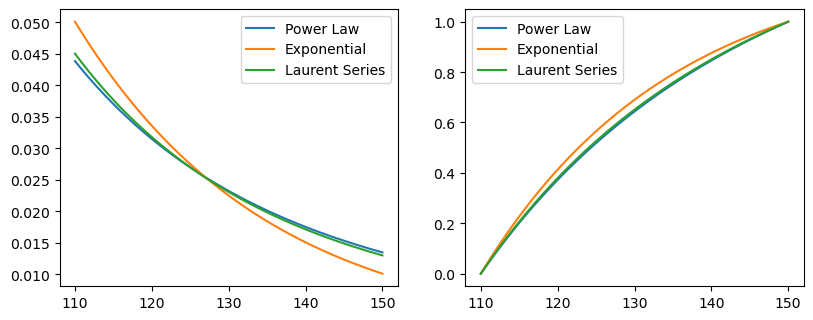

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(9.6,3.6))
x = np.linspace(*xrange, 400)

bkgs = ['Power Law', 'Exponential', 'Laurent Series']
bkg_pars = [-3.8, -0.04, 0.8]
bkg_pdfs = [power_law_pdf, exponential_pdf, laurent_pdf]
bkg_cdfs = [power_law_cdf, exponential_cdf, laurent_cdf]

for name, pdf, cdf, p in zip( bkgs, bkg_pdfs, bkg_cdfs, bkg_pars ):
    
    ax[0].plot( x, pdf(x, p), label=name )
    ax[1].plot( x, cdf(x, p), label=name )
    ax[0].legend()
    ax[1].legend()

## Ok now define the signal + background pdfs

In [8]:
s_mean = 125
s_width = 1.19
s_norm = 50.8
from scipy.stats import norm

def s_pdf(x):
    sigN = np.diff( norm.cdf(xrange, s_mean, s_width))
    return norm.pdf(x, s_mean, s_width) / sigN

def s_cdf(x):
    delta = norm.cdf(xrange[0], s_mean, s_width)
    sigN = np.diff( norm.cdf(xrange, s_mean, s_width))
    return (norm.cdf(x, s_mean, s_width) - delta) / sigN

def s_plus_power_law_pdf(x, mu, Nb, p):
    return mu * s_norm * s_pdf(x) + Nb * power_law_pdf(x, p)
    
def s_plus_exponential_pdf(x, mu, Nb, p):
    return mu * s_norm * s_pdf(x) + Nb * exponential_pdf(x, p)
        
def s_plus_laurent_pdf(x, mu, Nb, p):
    return mu * s_norm * s_pdf(x) + Nb * laurent_pdf(x, p)
        
def s_plus_power_law_cdf(x, mu, Nb, p):
    return mu * s_norm * s_cdf(x) + Nb * power_law_cdf(x, p)
    
def s_plus_exponential_cdf(x, mu, Nb, p):
    return mu * s_norm * s_cdf(x) + Nb * exponential_cdf(x, p)
        
def s_plus_laurent_cdf(x, mu, Nb, p):
    return mu * s_norm * s_cdf(x) + Nb * laurent_cdf(x, p)
        

splusb_pdfs = [ s_plus_power_law_pdf, s_plus_exponential_pdf, s_plus_laurent_pdf ]
splusb_cdfs = [ s_plus_power_law_cdf, s_plus_exponential_cdf, s_plus_laurent_cdf ]

And plot them

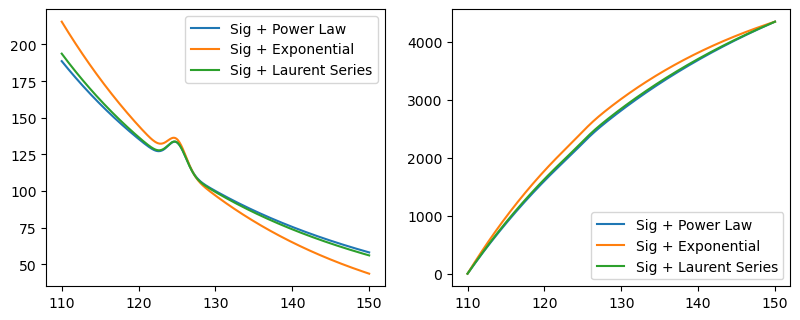

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(9.6,3.6))

for name, pdf, cdf, p in zip( bkgs, splusb_pdfs, splusb_cdfs, bkg_pars ): 
    ax[0].plot( x, pdf(x, mu=1, Nb=n_events, p=p), label=f'Sig + {name}' )
    ax[1].plot( x, cdf(x, mu=1, Nb=n_events, p=p), label=f'Sig + {name}' )
    ax[0].legend()
    ax[1].legend()

## Think I'm actually ready to fit the data
- Going to use `iminuit` which has built in cost functions for this kind of thing
- Will perform a binned maximum likleihood fit
- Will also profile the likelihood using the `mnprofile` method to make the likelihood scan plots
- In general I'm seeing fit quality $\chi^2 / dof \approx 1$ so I think the fits are ok
- It is true there is not a hugely significant signal seen but that was a reflection of the Higgs search at the time
- In this case we are investigating the impact of modelling the background and if there is a lot of signal this is less important

In [10]:
from iminuit import Minuit, cost

In [11]:
bkg_pars = [-3.8, -0.04, 0.8]
bkg_par_limits = [(-8,-2), (-0.4,-0.001), (0,1)]

fit_values = []
fit_errors = []
nll_scans = []

for name, cdf, par, limit in zip( bkgs, splusb_cdfs, bkg_pars, bkg_par_limits ):
    
    nll = cost.ExtendedBinnedNLL( bin_counts, bin_edges, cdf )
    
    mi = Minuit(nll, mu=1, Nb=np.sum(bin_counts), p=par)
    mi.limits['p'] = limit
    mi.limits['mu'] = (0,4)
    mi.limits['Nb'] = (0.5*np.sum(bin_counts), 1.5*np.sum(bin_counts))
    mi.migrad()
    mi.hesse()
    mi.minos('mu')
    x_scan, y_scan, valid = mi.mnprofile('mu')
    nll_scans.append( ( x_scan[valid], y_scan[valid] ) )
    fit_values.append( mi.values.to_dict())
    fit_errors.append( mi.errors.to_dict())
    print(f"FIT RESULT FOR SIGNAL + {name.upper()}")
    print(mi)

FIT RESULT FOR SIGNAL + POWER LAW
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 204.4 (χ²/ndof = 1.3)      │              Nfcn = 100              │
│ EDM = 1.27e-06 (Goal: 0.0002)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬─────

## Plot the fit results

Text(0, 0.5, '-2NLL')

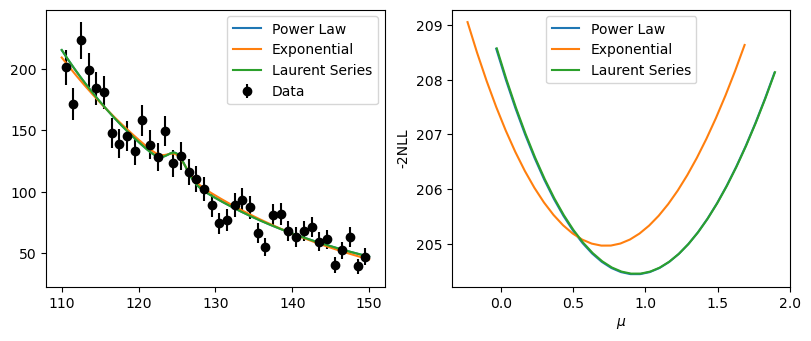

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(9.6,3.6))

# merge the bins?
merge = 4
xe = bin_edges[::merge]
nh = np.asarray( [sum(bin_counts[i:merge+i]) for i in range(0, len(bin_counts), merge)] )
cx = 0.5 * (xe[1:] + xe[:-1])
bw = xe[1] - xe[0]
N = sum(nh)

# points
ax[0].errorbar( cx, nh, nh**0.5, fmt='ko', label='Data' )

# fit results
for name, pdf, fit_val, nll_scan in zip( bkgs, splusb_pdfs, fit_values, nll_scans ):
    y = pdf( x, **fit_val )
    ax[0].plot(x, y, label=name)
    
    ax[1].plot(nll_scan[0], nll_scan[1], label=name)

ax[0].legend()
ax[1].legend()
ax[1].set_xlabel('$\mu$')
ax[1].set_ylabel('-2NLL')
    
    

